In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import string

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

Load dataset

In [23]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

Tương quan giữa các class 0 (fake news) và 1 (true news) trên tập train

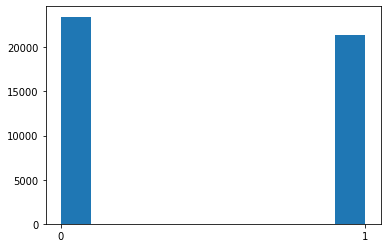

In [24]:
plt.figure()
plt.hist(df_train['class'])
plt.xticks(df_train['class'].unique())
plt.show()

Số lượng item của mỗi tập xấp xỉ nhau nên không sợ unbalanced.

## Tiền xử lý text
Gồm các bước sau:
- Chuyển text về dạng lowercase.
- Loại bỏ các dấu ngoặc.
- Loại bỏ các ký tự đặc biệt (chỉ cho phép a-z, A-Z, 0-9), thay thế bằng dấu cách.
- Loại bỏ html tags.
- Loại bỏ dấu câu (string punctuations).
- Loại bỏ dấu xuống dòng.
- Loại bỏ số trong câu.

In [25]:
def preprocess(text):
    punctuations = '[{0}]'.format(string.punctuation)
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(punctuations, '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

Áp dụng text preprocessing với df_train

In [26]:
df_train['text'].apply(preprocess)

0        moscow  reuters    russia and the united state...
1        republican rep  steve king  the base is going ...
2        monrovia  reuters    liberia s ruling party  w...
3        washington  reuters    u s  senators stressed ...
4        why are banking powerhouses  european prime mi...
                               ...                        
44873    abuja  reuters    the united states has formal...
44874    tune in to the alternate current radio network...
44875    the main stream media chooses to ignore the fa...
44876    washington  reuters    the republican tax plan...
44877    sydney  reuters    the u n  high commissioner ...
Name: text, Length: 44878, dtype: object

## Train model

Chia tập train thành train và validate.

In [27]:
X = df_train['text']
y = df_train['class']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X cần được chuyển thành vector trước khi đưa vào các model. Ở đây ta dùng TF-IDF vectorizer.

In [29]:
vectorizer = TfidfVectorizer()
XVector_train = vectorizer.fit_transform(X_train)

# Test không có fit!
XVector_test = vectorizer.transform(X_test)

In [30]:
# Export vectorizer ra file pickle

### Logistic Regression

In [31]:
logistic_model = LogisticRegression()
logistic_model.fit(XVector_train, y_train)

LogisticRegression()

In [32]:
logistic_model.score(XVector_test, y_test)

0.9852941176470589

In [33]:
predict_logistic_regression = logistic_model.predict(XVector_test)
print(classification_report(y_test, predict_logistic_regression))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6967
           1       0.98      0.99      0.98      6497

    accuracy                           0.99     13464
   macro avg       0.99      0.99      0.99     13464
weighted avg       0.99      0.99      0.99     13464



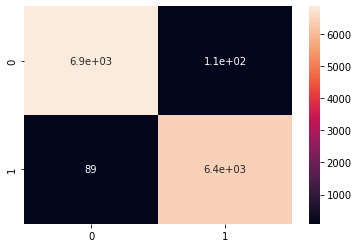

In [34]:
logistic_cm = confusion_matrix(y_test, predict_logistic_regression)
sns.heatmap(logistic_cm, annot = True)
plt.show()

In [35]:
# Export model ra file pickle

### Decision Tree Classification

In [36]:
decision_model = DecisionTreeClassifier(random_state = 42)
decision_model.fit(XVector_train, y_train)

DecisionTreeClassifier(random_state=42)

In [37]:
decision_model.score(XVector_test, y_test)

0.9955436720142602

In [38]:
predict_decision_tree = decision_model.predict(XVector_test)
print(classification_report(y_test, predict_decision_tree))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6967
           1       1.00      0.99      1.00      6497

    accuracy                           1.00     13464
   macro avg       1.00      1.00      1.00     13464
weighted avg       1.00      1.00      1.00     13464



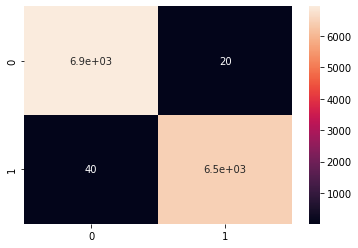

In [39]:
decision_cm = confusion_matrix(y_test, predict_decision_tree)
sns.heatmap(decision_cm, annot = True)
plt.show()

Nhận xét: Accuracy tăng, model này tốt hơn Logistic Regression.

In [40]:
# Export ra file pickle